In [1]:
import torch
print(torch.cuda.is_available())


True


In [2]:
import os
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [3]:
base_path = '/kaggle/input/dl-project-dataset/Split Preprocessed Data'

def load_split_data(base_path, split):
    split_path = os.path.join(base_path, split)
    data = []
    labels = []
    era_mapping = {
        "1850": "1800-1850",
        "1900": "1850-1900",
        "1950": "1900-1950",
        "2000": "1950-2000",
        "2024": "2000-2024",
    }
    for folder_name in os.listdir(split_path):
        era_label = era_mapping[folder_name]
        folder_path = os.path.join(split_path, folder_name)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                data.append(f.read())
                labels.append(era_label)

    return pd.DataFrame({'text': data, 'label': labels})

# Load datasets
train_data = load_split_data(base_path, 'train')
val_data = load_split_data(base_path, 'val')
test_data = load_split_data(base_path, 'test')

print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_data)}")


Train samples: 5119, Validation samples: 639, Test samples: 644


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(data):
    return tokenizer(list(data['text']), truncation=True, padding=True, max_length=512)

train_encodings = tokenize_data(train_data)
val_encodings = tokenize_data(val_data)
test_encodings = tokenize_data(test_data)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [5]:
era_to_label = {era: idx for idx, era in enumerate(train_data['label'].unique())}
label_to_era = {idx: era for era, idx in era_to_label.items()}

train_data['numeric_label'] = train_data['label'].map(era_to_label)
val_data['numeric_label'] = val_data['label'].map(era_to_label)
test_data['numeric_label'] = test_data['label'].map(era_to_label)


In [6]:
class EraDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = EraDataset(train_encodings, train_data['numeric_label'].values)
val_dataset = EraDataset(val_encodings, val_data['numeric_label'].values)
test_dataset = EraDataset(test_encodings, test_data['numeric_label'].values)


In [7]:
num_labels = len(era_to_label)  # Number of unique eras
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=num_labels)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    report_to="none"
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)


In [10]:
trainer.train()

# Save the model and tokenizer
model.save_pretrained('./mbert_model')
tokenizer.save_pretrained('./mbert_model')


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


('./mbert_model/tokenizer_config.json',
 './mbert_model/special_tokens_map.json',
 './mbert_model/vocab.txt',
 './mbert_model/added_tokens.json')

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


              precision    recall  f1-score   support

   2000-2024       0.98      0.97      0.98       254
   1800-1850       0.98      1.00      0.99        86
   1850-1900       0.98      0.94      0.96        65
   1900-1950       0.99      0.99      0.99       116
   1950-2000       0.96      0.99      0.98       123

    accuracy                           0.98       644
   macro avg       0.98      0.98      0.98       644
weighted avg       0.98      0.98      0.98       644



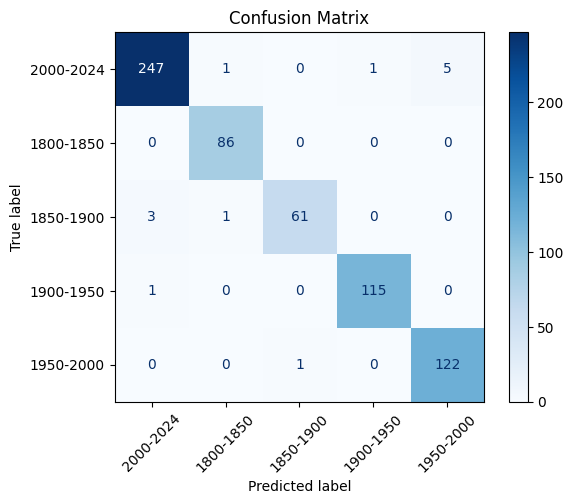

In [13]:
# Evaluate the test dataset
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Classification report
print(classification_report(test_data['numeric_label'], predicted_labels, target_names=list(label_to_era.values())))

# Generate confusion matrix
y_true = test_data['numeric_label']
y_pred = predicted_labels  # Predicted labels from the model

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_to_era.values()))

# Plot the confusion matrix with tilted x-axis
disp.plot(cmap='Blues', xticks_rotation=45)  # Rotates the x-axis labels by 45 degrees
plt.title("Confusion Matrix")
plt.show()
